# Chapter 5: Residual Plots & Counterfactual Reasoning

**Visualizing What Each Predictor Adds**

## Goal

Create **predictor residual plots** and **counterfactual plots** to understand:

1. **Predictor Residual Plots**: What does each predictor add *after* controlling for others?
2. **Counterfactual Plots**: What happens when we manipulate one predictor while holding others constant?
3. **Posterior Predictions**: Visualize model predictions across the full posterior
4. **Simulating Spurious Associations**: Understanding how confounding creates false relationships

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Prepare Data and Refit Models

We'll need M5.1, M5.2, and M5.3 for comparisons.

In [3]:
# Load and standardize data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
waffle_data = pd.read_csv(url, sep=";")

# Extract and standardize
divorce = waffle_data['Divorce'].values
marriage = waffle_data['Marriage'].values
age = waffle_data['MedianAgeMarriage'].values

D = (divorce - divorce.mean()) / divorce.std()
M = (marriage - marriage.mean()) / marriage.std()
A = (age - age.mean()) / age.std()

print(f"Sample size: {len(D)}")
print(f"Variables standardized: D (Divorce), M (Marriage), A (Age)")

Sample size: 50
Variables standardized: D (Divorce), M (Marriage), A (Age)


In [4]:
# Refit all three models

# M5.1: D ~ A
def neg_log_posterior_m51(params):
    alpha, beta_A, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_A * A
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_A, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m51 = quap(neg_log_posterior_m51, [0, 0, np.log(1)], ['alpha', 'beta_A', 'log_sigma'])

# M5.2: D ~ M
def neg_log_posterior_m52(params):
    alpha, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_M * M
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_M, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m52 = quap(neg_log_posterior_m52, [0, 0, np.log(1)], ['alpha', 'beta_M', 'log_sigma'])

# M5.3: D ~ A + M
def neg_log_posterior_m53(params):
    alpha, beta_A, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_A * A + beta_M * M
    log_lik = np.sum(stats.norm.logpdf(D, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_A, 0, 0.5) +
                 stats.norm.logpdf(beta_M, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m53 = quap(neg_log_posterior_m53, [0, 0, 0, np.log(1)], 
           ['alpha', 'beta_A', 'beta_M', 'log_sigma'])

print("✓ All models fitted")
print("\nModel summaries:")
print("\nM5.1 (D ~ Age):")
m51.summary()
print("\nM5.2 (D ~ Marriage):")
m52.summary()
print("\nM5.3 (D ~ Age + Marriage):")
m53.summary()

✓ All models fitted

Model summaries:

M5.1 (D ~ Age):
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0166 seconds
Log posterior at MAP: -61.15

             mean    std  89%_lower  89%_upper
alpha     -0.0000 0.0989    -0.1580     0.1580
beta_A    -0.5679 0.1110    -0.7453    -0.3904
log_sigma -0.2179 0.0999    -0.3776    -0.0582

M5.2 (D ~ Marriage):
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0093 seconds
Log posterior at MAP: -67.99

             mean    std  89%_lower  89%_upper
alpha      0.0000 0.1098    -0.1754     0.1754
beta_M     0.3496 0.1271     0.1465     0.5527
log_sigma -0.0742 0.0997    -0.2335     0.0851

M5.3 (D ~ Age + Marriage):
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0155 seconds
Log posterior at MAP: -61.29

             mean    std  89%_lower  89%_upper
alpha     -0.0000 0.0986    -0.1575     0.1575
beta_A    -0.6123 0.1523    -0.8557    -0.3689
beta_M    -0.0645 0.1521    -0.3075     0.1785
log_sigma -0.2220 0.1001    -0.3820    -0.0

,mean,std,89%_lower,89%_upper
alpha,-3.133631e-09,0.098560,-0.157519,0.157519
beta_A,-6.123302e-01,0.152290,-0.855720,-0.368941
beta_M,-6.450689e-02,0.152071,-0.307545,0.178531
log_sigma,-2.219740e-01,0.100118,-0.381982,-0.061966


---

## Part 1: Predictor Residual Plots

**Key Question:** What does each predictor add *after* accounting for the other?

### What are Predictor Residuals?

**Predictor residuals** show what's left of a predictor after removing the influence of other predictors.

For example, to see what **Age adds beyond Marriage**:
1. Regress Age on Marriage: `A ~ M`
2. Compute residuals: `A_resid = A - predicted(A|M)`
3. Plot: `D vs A_resid`

**Interpretation:** This shows the relationship between Divorce and the part of Age that's *uncorrelated* with Marriage.

---

### Compute Predictor Residuals

In [5]:
# Step 1: Regress A on M (to get age residuals)
def neg_log_posterior_A_on_M(params):
    """A ~ alpha + beta*M"""
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * M
    log_lik = np.sum(stats.norm.logpdf(A, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_A_on_M = quap(neg_log_posterior_A_on_M, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])

# Predicted age from marriage
coef_A_M = m_A_on_M.coef()
A_pred_from_M = coef_A_M['alpha'] + coef_A_M['beta'] * M
A_resid = A - A_pred_from_M

print("Age residuals (after removing Marriage effect):")
print(f"  Mean: {A_resid.mean():.3f}")
print(f"  Std:  {A_resid.std():.3f}")
print(f"  Correlation with M: {np.corrcoef(A_resid, M)[0,1]:.3f}")

Age residuals (after removing Marriage effect):
  Mean: 0.000
  Std:  0.693
  Correlation with M: -0.039


In [6]:
# Step 2: Regress M on A (to get marriage residuals)
def neg_log_posterior_M_on_A(params):
    """M ~ alpha + beta*A"""
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * A
    log_lik = np.sum(stats.norm.logpdf(M, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_M_on_A = quap(neg_log_posterior_M_on_A, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])

# Predicted marriage from age
coef_M_A = m_M_on_A.coef()
M_pred_from_A = coef_M_A['alpha'] + coef_M_A['beta'] * A
M_resid = M - M_pred_from_A

print("Marriage residuals (after removing Age effect):")
print(f"  Mean: {M_resid.mean():.3f}")
print(f"  Std:  {M_resid.std():.3f}")
print(f"  Correlation with A: {np.corrcoef(M_resid, A)[0,1]:.3f}")

Marriage residuals (after removing Age effect):
  Mean: 0.000
  Std:  0.693
  Correlation with A: -0.039


### Predictor Residual Plots

Now let's plot Divorce against these residuals.

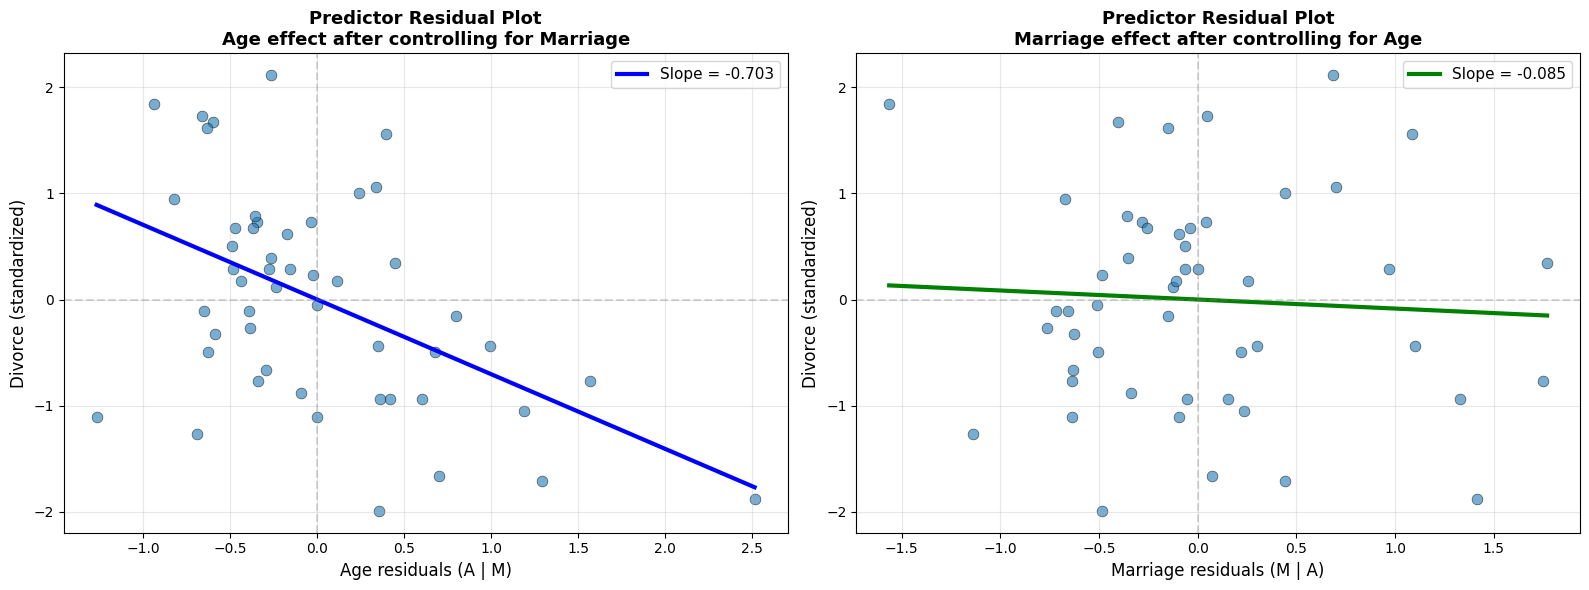


Comparison with M5.3 coefficients:
Age residual slope:      -0.703
M5.3 beta_A:             -0.612
Marriage residual slope: -0.085
M5.3 beta_M:             -0.065

✓ Slopes match the multiple regression coefficients!


In [7]:
# Create predictor residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Divorce vs Age residuals (age after removing marriage)
ax = axes[0]
ax.scatter(A_resid, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5)

# Add regression line
slope, intercept = np.polyfit(A_resid, D, 1)
x_line = np.linspace(A_resid.min(), A_resid.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'b-', linewidth=3, label=f'Slope = {slope:.3f}')

ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Age residuals (A | M)', fontsize=12)
ax.set_ylabel('Divorce (standardized)', fontsize=12)
ax.set_title('Predictor Residual Plot\nAge effect after controlling for Marriage', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Divorce vs Marriage residuals (marriage after removing age)
ax = axes[1]
ax.scatter(M_resid, D, alpha=0.6, s=60, edgecolor='black', linewidth=0.5)

# Add regression line
slope2, intercept2 = np.polyfit(M_resid, D, 1)
x_line2 = np.linspace(M_resid.min(), M_resid.max(), 100)
y_line2 = slope2 * x_line2 + intercept2
ax.plot(x_line2, y_line2, 'g-', linewidth=3, label=f'Slope = {slope2:.3f}')

ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Marriage residuals (M | A)', fontsize=12)
ax.set_ylabel('Divorce (standardized)', fontsize=12)
ax.set_title('Predictor Residual Plot\nMarriage effect after controlling for Age', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with M5.3 coefficients
coef_m53 = m53.coef()
print("\nComparison with M5.3 coefficients:")
print("="*70)
print(f"Age residual slope:      {slope:.3f}")
print(f"M5.3 beta_A:             {coef_m53['beta_A']:.3f}")
print(f"Marriage residual slope: {slope2:.3f}")
print(f"M5.3 beta_M:             {coef_m53['beta_M']:.3f}")
print("\n✓ Slopes match the multiple regression coefficients!")

### Key Insight from Residual Plots

**The slopes in the residual plots ARE the multiple regression coefficients!**

- **Age residual slope ≈ β_A from M5.3**: Strong negative relationship
- **Marriage residual slope ≈ β_M from M5.3**: Near zero!

This visualizes why **Marriage has no effect after controlling for Age**:
- Once we remove Age's influence from Marriage, what's left has no relationship with Divorce
- But Age residuals (after removing Marriage) still strongly predict Divorce

**This is the geometric meaning of multiple regression!**

---

## Part 2: Counterfactual Plots

**Key Question:** What happens to Divorce if we manipulate one variable while holding others constant?

### Two Types of Counterfactual Plots

1. **Holding Marriage at its mean**: How does Divorce change with Age when M = 0?
2. **Holding Age at its mean**: How does Divorce change with Marriage when A = 0?

These show **causal effects** under the assumption that we can intervene on predictors.

---

In [8]:
# Sample from M5.3 posterior
post_m53 = m53.sample(n=1000, seed=42)

# Extract samples
alpha_samples = post_m53['alpha'].values
beta_A_samples = post_m53['beta_A'].values
beta_M_samples = post_m53['beta_M'].values

print(f"Posterior samples: {len(alpha_samples)}")

Posterior samples: 1000


### Counterfactual 1: Varying Age (holding Marriage = 0)

**Scenario:** What if we manipulate age while keeping marriage rate at average?

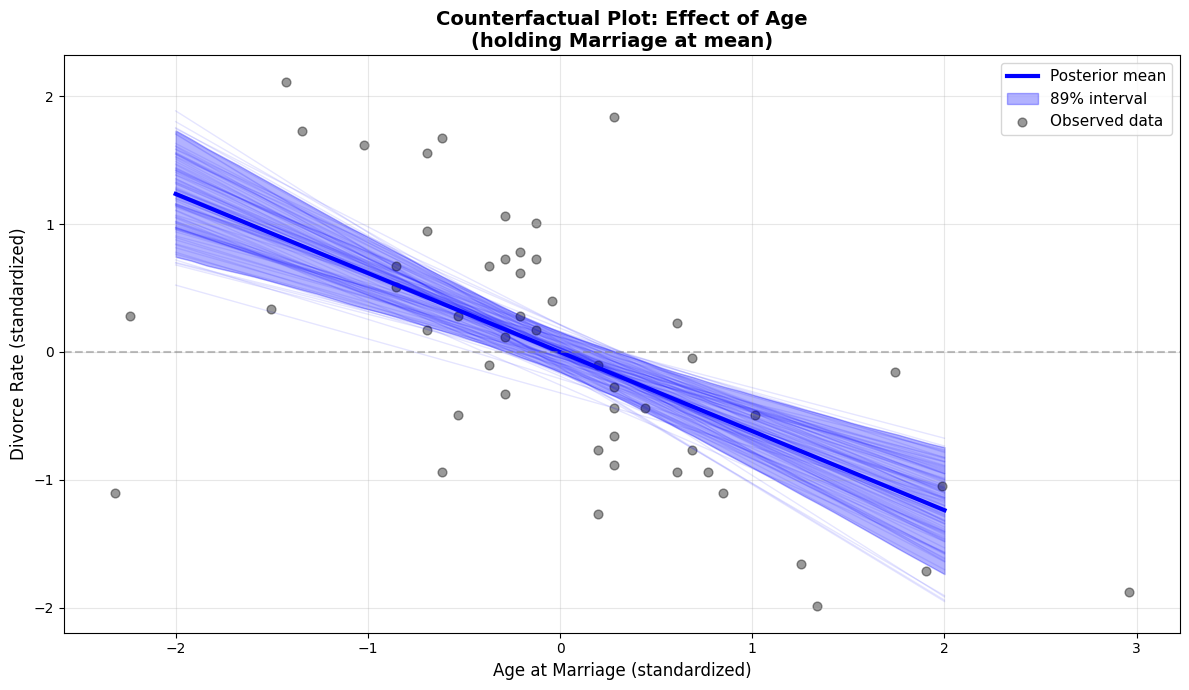

Interpretation:
• Strong NEGATIVE effect of Age on Divorce
• Uncertainty is relatively small
• If we increase age by 1 SD, divorce decreases by ~0.6 SD


In [9]:
# Create sequence of Age values
A_seq = np.linspace(-2, 2, 50)
M_counterfactual = 0  # Hold Marriage at mean (standardized)

# Compute predicted Divorce for each posterior sample
D_counterfactual_A = (alpha_samples[:, None] + 
                       beta_A_samples[:, None] * A_seq[None, :] + 
                       beta_M_samples[:, None] * M_counterfactual)

# Compute summary statistics
D_mean_A = D_counterfactual_A.mean(axis=0)
D_lower_A = np.percentile(D_counterfactual_A, 5.5, axis=0)
D_upper_A = np.percentile(D_counterfactual_A, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 7))

# Spaghetti plot: sample of posterior lines
for i in range(100):
    plt.plot(A_seq, D_counterfactual_A[i], 'b-', alpha=0.1, linewidth=1)

# Mean line
plt.plot(A_seq, D_mean_A, 'b-', linewidth=3, label='Posterior mean')

# Uncertainty band
plt.fill_between(A_seq, D_lower_A, D_upper_A, alpha=0.3, color='blue', 
                 label='89% interval')

# Observed data (for reference)
plt.scatter(A, D, alpha=0.4, s=40, color='black', label='Observed data')

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Age at Marriage (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('Counterfactual Plot: Effect of Age\n(holding Marriage at mean)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Strong NEGATIVE effect of Age on Divorce")
print("• Uncertainty is relatively small")
print("• If we increase age by 1 SD, divorce decreases by ~0.6 SD")

### Counterfactual 2: Varying Marriage (holding Age = 0)

**Scenario:** What if we manipulate marriage rate while keeping age at average?

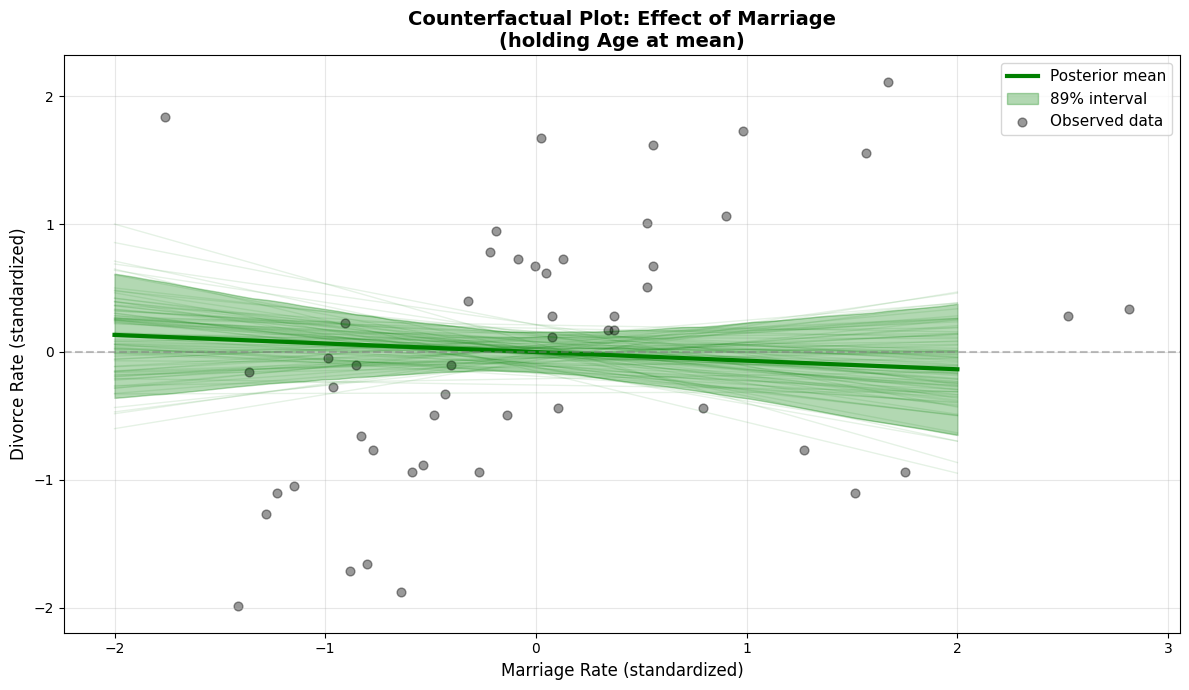

Interpretation:
• NEARLY FLAT relationship (slope ≈ 0)
• Marriage has NO effect after controlling for Age
• The earlier positive correlation was spurious!


In [10]:
# Create sequence of Marriage values
M_seq = np.linspace(-2, 2, 50)
A_counterfactual = 0  # Hold Age at mean (standardized)

# Compute predicted Divorce
D_counterfactual_M = (alpha_samples[:, None] + 
                       beta_A_samples[:, None] * A_counterfactual + 
                       beta_M_samples[:, None] * M_seq[None, :])

# Summary statistics
D_mean_M = D_counterfactual_M.mean(axis=0)
D_lower_M = np.percentile(D_counterfactual_M, 5.5, axis=0)
D_upper_M = np.percentile(D_counterfactual_M, 94.5, axis=0)

# Plot
plt.figure(figsize=(12, 7))

# Spaghetti plot
for i in range(100):
    plt.plot(M_seq, D_counterfactual_M[i], 'g-', alpha=0.1, linewidth=1)

# Mean line
plt.plot(M_seq, D_mean_M, 'g-', linewidth=3, label='Posterior mean')

# Uncertainty band
plt.fill_between(M_seq, D_lower_M, D_upper_M, alpha=0.3, color='green', 
                 label='89% interval')

# Observed data
plt.scatter(M, D, alpha=0.4, s=40, color='black', label='Observed data')

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Marriage Rate (standardized)', fontsize=12)
plt.ylabel('Divorce Rate (standardized)', fontsize=12)
plt.title('Counterfactual Plot: Effect of Marriage\n(holding Age at mean)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("• NEARLY FLAT relationship (slope ≈ 0)")
print("• Marriage has NO effect after controlling for Age")
print("• The earlier positive correlation was spurious!")

### Side-by-Side Counterfactual Comparison

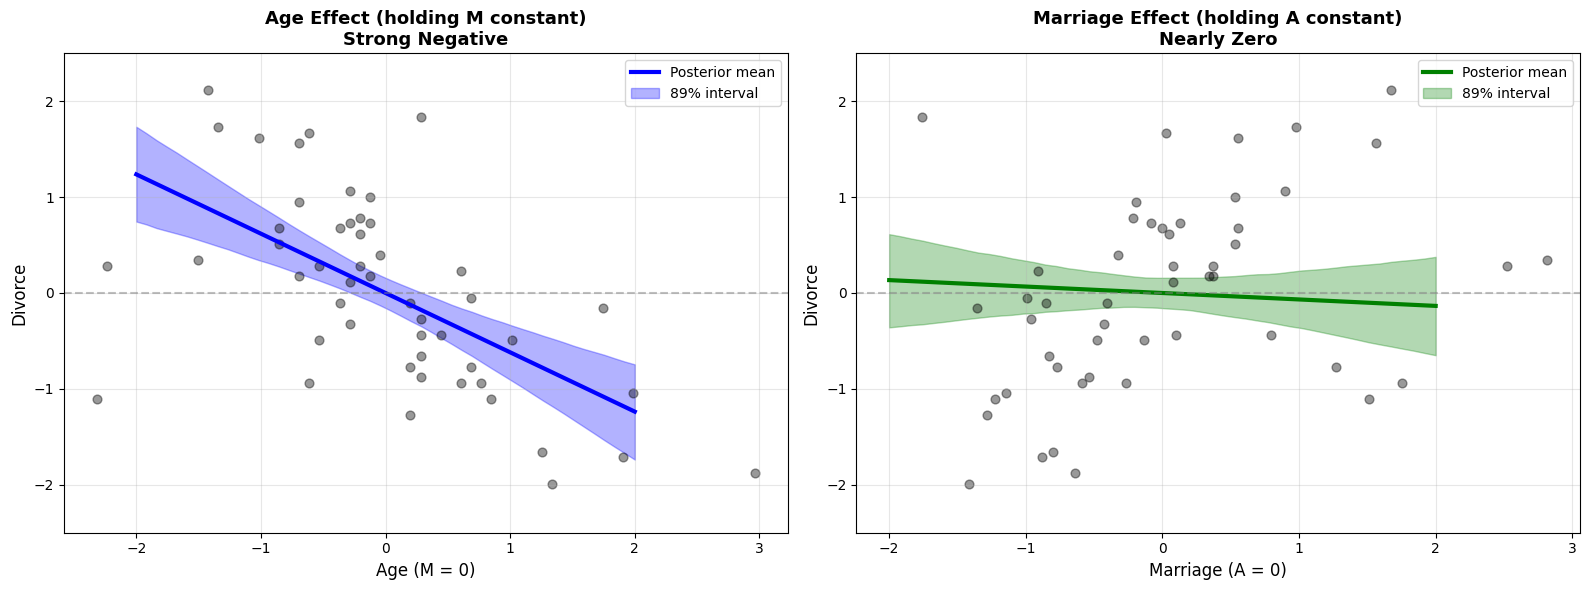


Key Takeaway:
Age matters, Marriage doesn't (after controlling for Age)


In [11]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Age effect
ax = axes[0]
ax.plot(A_seq, D_mean_A, 'b-', linewidth=3, label='Posterior mean')
ax.fill_between(A_seq, D_lower_A, D_upper_A, alpha=0.3, color='blue', 
                label='89% interval')
ax.scatter(A, D, alpha=0.4, s=40, color='black')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Age (M = 0)', fontsize=12)
ax.set_ylabel('Divorce', fontsize=12)
ax.set_title('Age Effect (holding M constant)\nStrong Negative', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-2.5, 2.5)

# Plot 2: Marriage effect
ax = axes[1]
ax.plot(M_seq, D_mean_M, 'g-', linewidth=3, label='Posterior mean')
ax.fill_between(M_seq, D_lower_M, D_upper_M, alpha=0.3, color='green', 
                label='89% interval')
ax.scatter(M, D, alpha=0.4, s=40, color='black')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Marriage (A = 0)', fontsize=12)
ax.set_ylabel('Divorce', fontsize=12)
ax.set_title('Marriage Effect (holding A constant)\nNearly Zero', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

print("\nKey Takeaway:")
print("="*70)
print("Age matters, Marriage doesn't (after controlling for Age)")

---

## Part 3: Simulating Spurious Association

**Goal:** Understand *how* confounding creates spurious associations.

### The Causal Structure (DAG)

```
       A (Age)
      / \
     /   \
    ↓     ↓
   M      D
```

**True causal structure:**
- Age → Divorce (real effect)
- Age → Marriage (real effect)
- Marriage ↛ Divorce (NO direct effect)

**But:** M and D will be *correlated* because they share a common cause (A).

Let's simulate this!

---

In [12]:
# Simulate data according to the DAG
n_sim = 100
np.random.seed(123)

# 1. Generate Age (independent)
A_sim = np.random.normal(0, 1, n_sim)

# 2. Generate Marriage from Age
#    M = -0.7*A + noise
#    (younger age → more marriages)
M_sim = -0.7 * A_sim + np.random.normal(0, 0.7, n_sim)

# 3. Generate Divorce from Age ONLY (no direct effect of M)
#    D = -0.6*A + noise
#    (younger age → more divorces)
D_sim = -0.6 * A_sim + np.random.normal(0, 0.8, n_sim)

print("Simulated data according to DAG:")
print("  A → M (coefficient: -0.7)")
print("  A → D (coefficient: -0.6)")
print("  M → D (coefficient: 0.0, no direct effect)")
print(f"\nSample size: {n_sim}")

Simulated data according to DAG:
  A → M (coefficient: -0.7)
  A → D (coefficient: -0.6)
  M → D (coefficient: 0.0, no direct effect)

Sample size: 100


In [13]:
# Compute correlations
corr_AD = np.corrcoef(A_sim, D_sim)[0, 1]
corr_MD = np.corrcoef(M_sim, D_sim)[0, 1]
corr_AM = np.corrcoef(A_sim, M_sim)[0, 1]

print("Correlations in simulated data:")
print("="*70)
print(f"  A ~ D: {corr_AD:.3f}  (true causal effect)")
print(f"  M ~ D: {corr_MD:.3f}  (spurious! M doesn't cause D)")
print(f"  A ~ M: {corr_AM:.3f}  (both caused by A)")
print("\n⚠️ M and D are correlated, but M does NOT cause D!")
print("   This is a SPURIOUS association via confounding.")

Correlations in simulated data:
  A ~ D: -0.683  (true causal effect)
  M ~ D: 0.532  (spurious! M doesn't cause D)
  A ~ M: -0.764  (both caused by A)

⚠️ M and D are correlated, but M does NOT cause D!
   This is a SPURIOUS association via confounding.


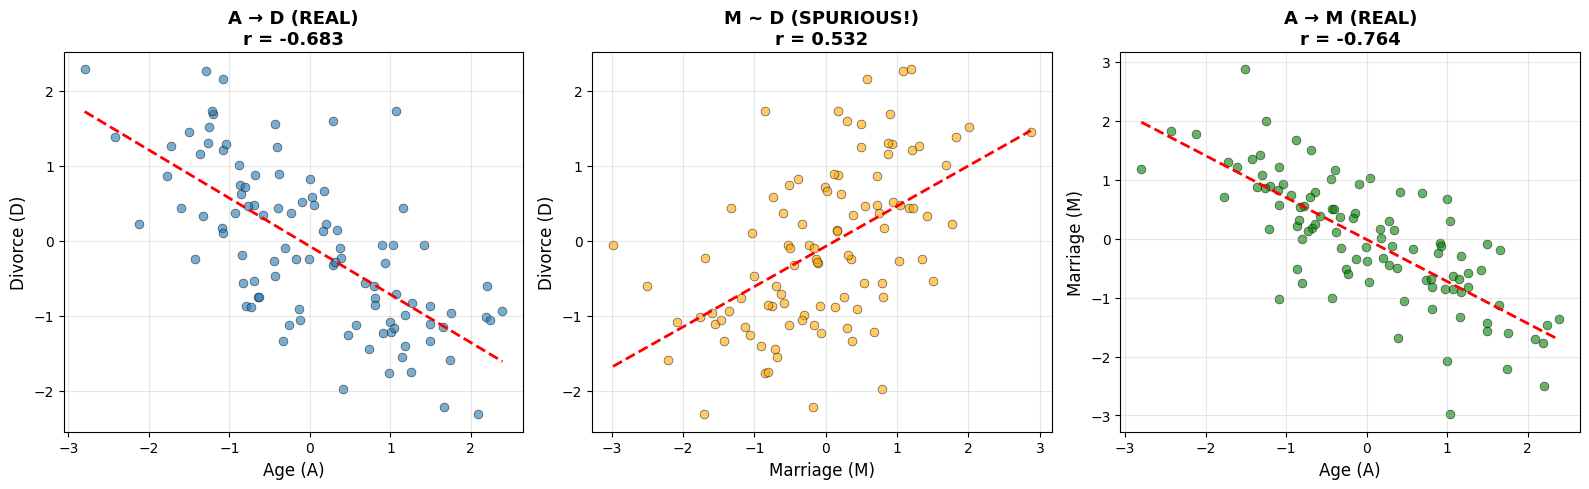


Key Insight:
M and D are correlated because they share a common cause (A).
This creates a spurious association!


In [14]:
# Visualize the spurious association
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: A → D (real)
ax = axes[0]
ax.scatter(A_sim, D_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5)
slope, intercept = np.polyfit(A_sim, D_sim, 1)
x_line = np.linspace(A_sim.min(), A_sim.max(), 100)
ax.plot(x_line, slope * x_line + intercept, 'r--', linewidth=2)
ax.set_xlabel('Age (A)', fontsize=12)
ax.set_ylabel('Divorce (D)', fontsize=12)
ax.set_title(f'A → D (REAL)\nr = {corr_AD:.3f}', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: M ~ D (spurious)
ax = axes[1]
ax.scatter(M_sim, D_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5, color='orange')
slope2, intercept2 = np.polyfit(M_sim, D_sim, 1)
x_line2 = np.linspace(M_sim.min(), M_sim.max(), 100)
ax.plot(x_line2, slope2 * x_line2 + intercept2, 'r--', linewidth=2)
ax.set_xlabel('Marriage (M)', fontsize=12)
ax.set_ylabel('Divorce (D)', fontsize=12)
ax.set_title(f'M ~ D (SPURIOUS!)\nr = {corr_MD:.3f}', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: A → M (real)
ax = axes[2]
ax.scatter(A_sim, M_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5, color='green')
slope3, intercept3 = np.polyfit(A_sim, M_sim, 1)
x_line3 = np.linspace(A_sim.min(), A_sim.max(), 100)
ax.plot(x_line3, slope3 * x_line3 + intercept3, 'r--', linewidth=2)
ax.set_xlabel('Age (A)', fontsize=12)
ax.set_ylabel('Marriage (M)', fontsize=12)
ax.set_title(f'A → M (REAL)\nr = {corr_AM:.3f}', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("M and D are correlated because they share a common cause (A).")
print("This creates a spurious association!")

### Now fit regressions to simulated data

Let's see if multiple regression recovers the truth.

In [15]:
# Fit simple regressions

# D ~ A
def neg_log_posterior_sim_DA(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * A_sim
    log_lik = np.sum(stats.norm.logpdf(D_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_DA = quap(neg_log_posterior_sim_DA, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])

# D ~ M
def neg_log_posterior_sim_DM(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * M_sim
    log_lik = np.sum(stats.norm.logpdf(D_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_DM = quap(neg_log_posterior_sim_DM, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])

# D ~ A + M (multiple regression)
def neg_log_posterior_sim_DAM(params):
    alpha, beta_A, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_A * A_sim + beta_M * M_sim
    log_lik = np.sum(stats.norm.logpdf(D_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta_A, 0, 1) +
                 stats.norm.logpdf(beta_M, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_DAM = quap(neg_log_posterior_sim_DAM, [0, 0, 0, np.log(1)], 
                 ['alpha', 'beta_A', 'beta_M', 'log_sigma'])

print("✓ Fitted models to simulated data")

✓ Fitted models to simulated data


In [16]:
# Extract coefficients
coef_DA = m_sim_DA.coef()
coef_DM = m_sim_DM.coef()
coef_DAM = m_sim_DAM.coef()

# Create comparison table
results = pd.DataFrame({
    'True Value': [-0.6, 0.0],
    'D ~ A only': [coef_DA['beta'], '—'],
    'D ~ M only': ['—', coef_DM['beta']],
    'D ~ A + M': [coef_DAM['beta_A'], coef_DAM['beta_M']]
}, index=['β_A (Age)', 'β_M (Marriage)'])

print("\nRecovering True Causal Effects:")
print("="*70)
print(results)
print("="*70)
print("\nObservations:")
print("• D ~ M shows a spurious positive effect (but true effect is 0!)")
print("• D ~ A + M correctly recovers:")
print("    - β_A ≈ -0.6 (true effect)")
print("    - β_M ≈ 0 (no direct effect)")
print("\n✓ Multiple regression reveals the truth!")


Recovering True Causal Effects:
                True Value D ~ A only D ~ M only  D ~ A + M
β_A (Age)             -0.6  -0.638438          —  -0.616288
β_M (Marriage)         0.0          —   0.532535   0.031275

Observations:
• D ~ M shows a spurious positive effect (but true effect is 0!)
• D ~ A + M correctly recovers:
    - β_A ≈ -0.6 (true effect)
    - β_M ≈ 0 (no direct effect)

✓ Multiple regression reveals the truth!


---

## Part 4: Posterior Prediction Intervals

Let's also visualize the **posterior predictive distribution** for M5.3.

In [17]:
# Generate posterior predictions for observed data
post_m53 = m53.sample(n=1000, seed=42)

alpha_post = post_m53['alpha'].values
beta_A_post = post_m53['beta_A'].values
beta_M_post = post_m53['beta_M'].values
sigma_post = np.exp(post_m53['log_sigma'].values)

# Compute mu for each observation
mu_post = (alpha_post[:, None] + 
           beta_A_post[:, None] * A[None, :] + 
           beta_M_post[:, None] * M[None, :])

# Generate predictions (including sigma)
D_pred = np.random.normal(mu_post, sigma_post[:, None])

# Summary stats
mu_mean = mu_post.mean(axis=0)
D_pred_mean = D_pred.mean(axis=0)
D_pred_lower = np.percentile(D_pred, 5.5, axis=0)
D_pred_upper = np.percentile(D_pred, 94.5, axis=0)

print(f"Generated posterior predictions for {len(D)} observations")

Generated posterior predictions for 50 observations


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


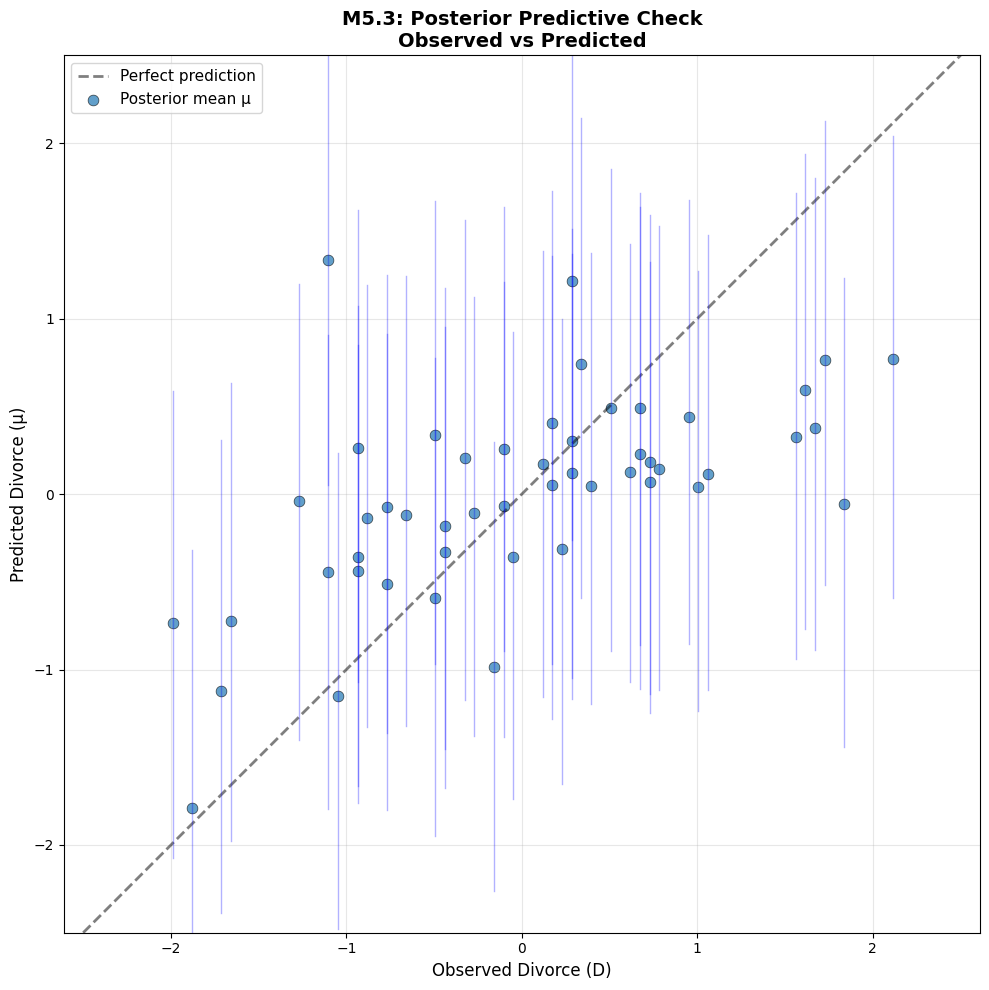


Residual statistics:
  Mean: 0.001
  Std:  0.799
  Max:  2.434


In [18]:
# Plot observed vs predicted
plt.figure(figsize=(10, 10))

# Perfect prediction line
plt.plot([-2.5, 2.5], [-2.5, 2.5], 'k--', linewidth=2, alpha=0.5, 
         label='Perfect prediction')

# Prediction intervals
for i in range(len(D)):
    plt.plot([D[i], D[i]], [D_pred_lower[i], D_pred_upper[i]], 
             'b-', alpha=0.3, linewidth=1)

# Mean predictions
plt.scatter(D, mu_mean, s=60, alpha=0.7, edgecolor='black', linewidth=0.5, 
            label='Posterior mean μ')

plt.xlabel('Observed Divorce (D)', fontsize=12)
plt.ylabel('Predicted Divorce (μ)', fontsize=12)
plt.title('M5.3: Posterior Predictive Check\nObserved vs Predicted', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.tight_layout()
plt.show()

# Compute residuals
residuals = D - mu_mean
print(f"\nResidual statistics:")
print(f"  Mean: {residuals.mean():.3f}")
print(f"  Std:  {residuals.std():.3f}")
print(f"  Max:  {np.abs(residuals).max():.3f}")

---

## Summary

### What We Learned

**1. Predictor Residual Plots**
- Show what each predictor contributes *after* accounting for others
- The slope of D vs predictor residuals = multiple regression coefficient
- Age residuals strongly predict Divorce
- Marriage residuals do NOT predict Divorce

**2. Counterfactual Plots**
- Show effect of manipulating one variable while holding others constant
- Age has strong causal effect on Divorce
- Marriage has NO effect after controlling for Age

**3. Simulating Spurious Associations**
- When variables share a common cause, they appear correlated
- This creates spurious associations
- Multiple regression can reveal the truth
- Causal structure (DAG) determines what to control for

**4. Posterior Predictions**
- Model fits the data well
- Residuals are small and centered at zero

### The Big Picture

**Multiple regression is essential for causal inference:**
- Simple correlations can be misleading
- Need to control for confounders
- Predictor residual plots and counterfactuals help interpret results
- Always think about causal structure (DAGs) before modeling

**Key Insight from Waffle Divorce:**
- Marriage rate appeared to matter
- But it was confounded by Age
- After controlling for Age, Marriage effect disappeared
- Age is the real driver of divorce rates

---

**End of Chapter 5**